In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_10nu import WMSE
from pitchfuncs_10nu import InversePCA
from pitchfuncs_10nu import emulator
from pitchfuncs_10nu import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time

2024-03-27 16:31:08.344041: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 16:31:08.344080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 16:31:08.344987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 16:31:08.349802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 16:31:08.877490: W tensorflow/compiler/tf2

In [2]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [3]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]
model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
2619361,0.92,0.010203,0.28,2.1,4.233043,0.930011,0.888626,5815.207896,0.009274,724.023798,...,0.845539,0.846405,0.847485,0.847855,0.848127,0.848946,0.849008,0.848094,0.846248,0.844458


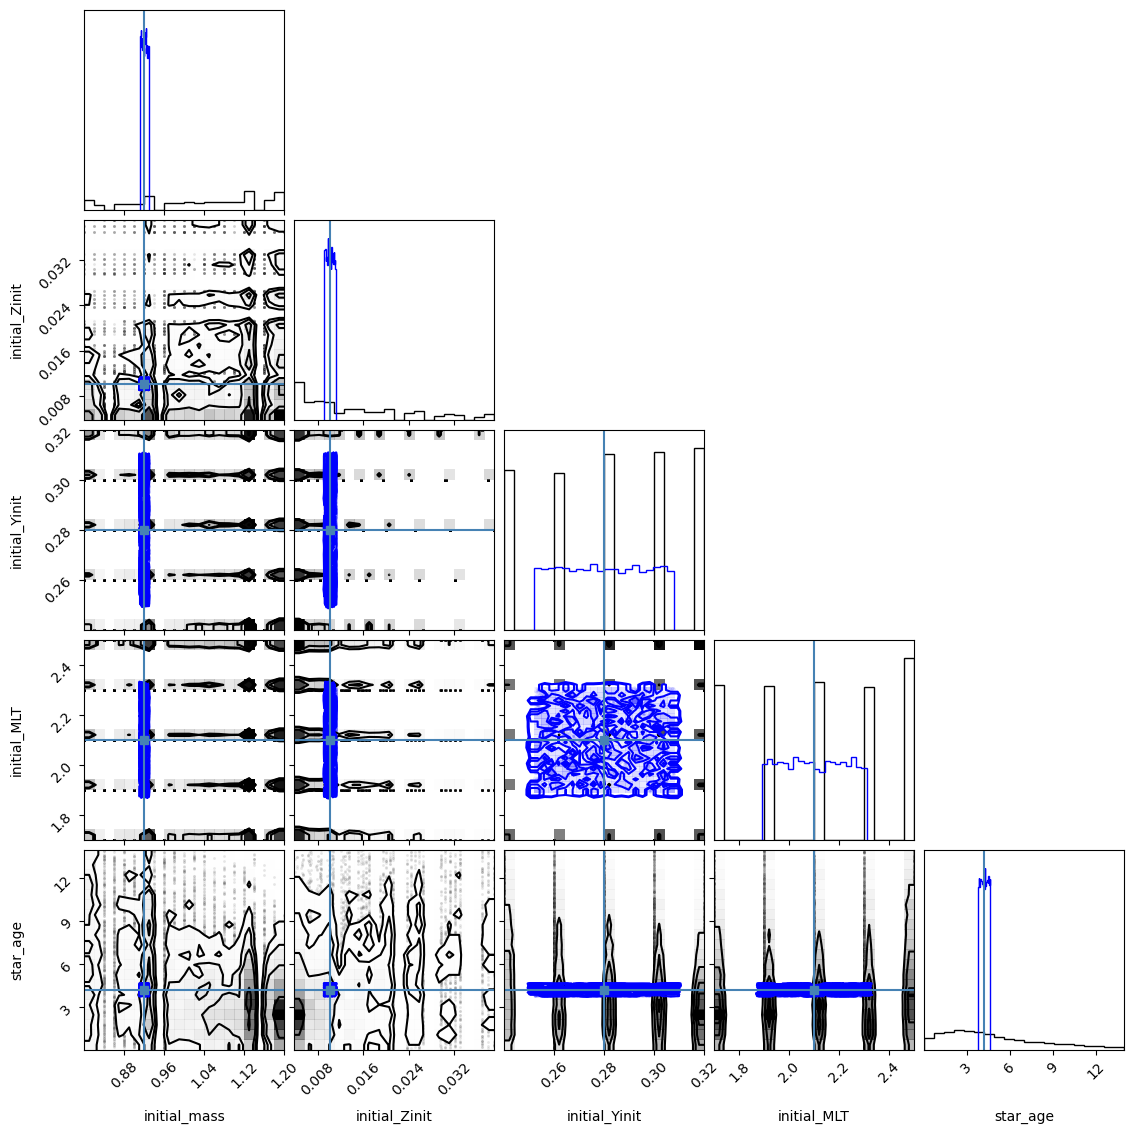

In [45]:
"""
Define priors
"""

def grid_uniform_prior(model_inps, header):
    model_min = model_inps[header].min()
    return scipy.stats.uniform(loc=model_min, scale=model_inps[header].max()-model_min)

def uniform_prior(model_inps, header, scale=0.1):
    model_min = model_inps[header]*(1-scale)
    return scipy.stats.uniform(loc=model_min, scale=(model_inps[header]*(1+scale))-model_min)

def normal_prior(model_inps, header, scale):
    return scipy.stats.norm(loc=model_inps[header], scale=scale)

mass_prior = uniform_prior(model_inps, "initial_mass",scale=0.01)

Zinit_prior = uniform_prior(model_inps,"initial_Zinit")

Yinit_prior = uniform_prior(model_inps, "initial_Yinit")

MLT_prior = uniform_prior(model_inps, "initial_MLT")

age_prior = uniform_prior(model_inps, "star_age")

priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000), hist_kwargs={'density':True});

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure,hist_kwargs={'density':True});

In [46]:
pitchfork = emulator("nu6-40_elu")

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [47]:
"""
Define observed quantities and uncertainties
"""
obs = pitchfork.predict(np.array(model_inps.values))
obs=np.concatenate((obs[:,:3],obs[:,15:25]),axis=1).tolist()[0]

unc = [5, 5, 5] + [5 for i in range(15,25)]

In [10]:
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)

In [17]:
theta = sampler.ptform([0.5,0.5,0.5,0.5,0.5])

In [18]:
m = pitchfork.predict(np.array([theta]))
m = np.concatenate((m[:,:3],m[:,15:25]), axis=1)
ll = scipy.stats.norm.logpdf(m, loc = obs, scale = unc).sum()
ll

-32.868893793304046

In [41]:
theta = sampler.ptform([0.6,0.5,0.5,0.5,0.5])

In [42]:
m = pitchfork.predict(np.array([theta]))
m = np.concatenate((m[:,:3],m[:,15:25]), axis=1)
ll = scipy.stats.norm.logpdf(m, loc = obs, scale = unc).sum()
ll

-5360.529744146982

iter: 2937 | +500 | bound: 16 | nc: 1 | ncall: 47433 | eff(%):  7.323 | loglstar:   -inf < -32.869 <    inf | logz: -37.834 +/-  0.082 | dlogz:  0.001 >  0.509                                       

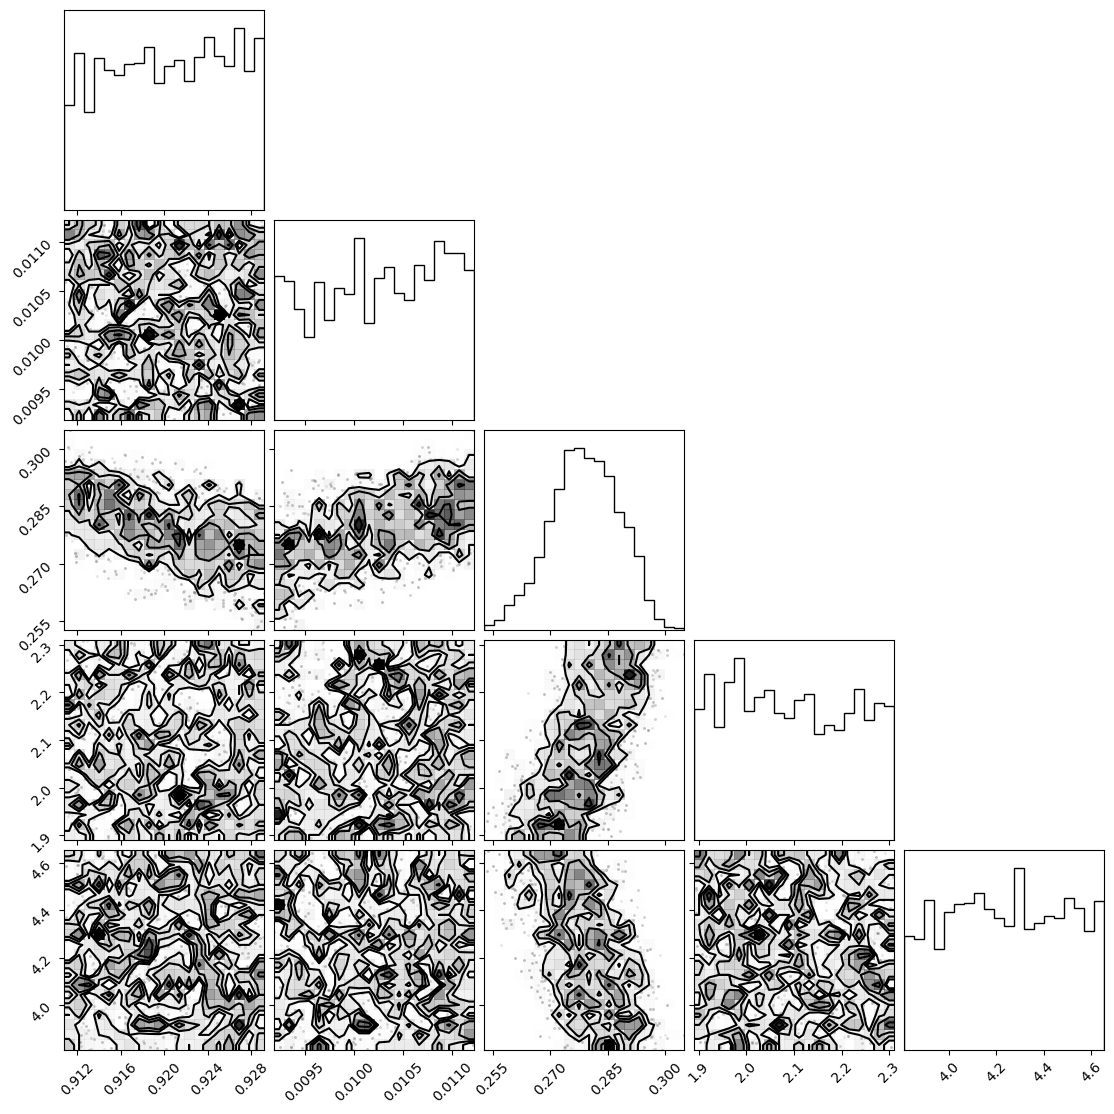

In [48]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)
posterior = sampler(nlive=500)
toc = time.time()

corner.corner(posterior);

562.2053329944611


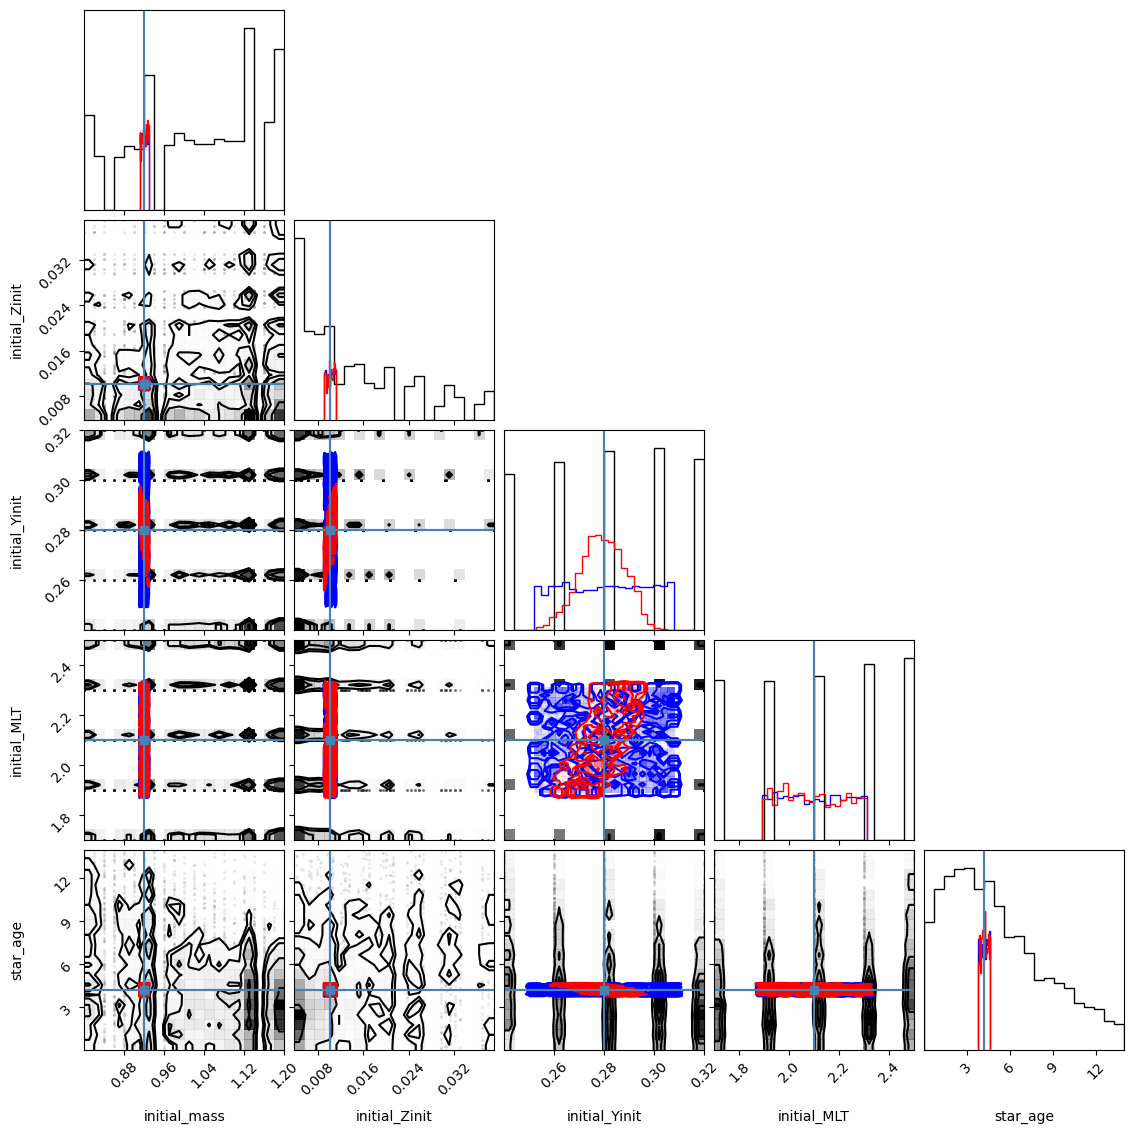

In [49]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));
print(toc-tic)
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

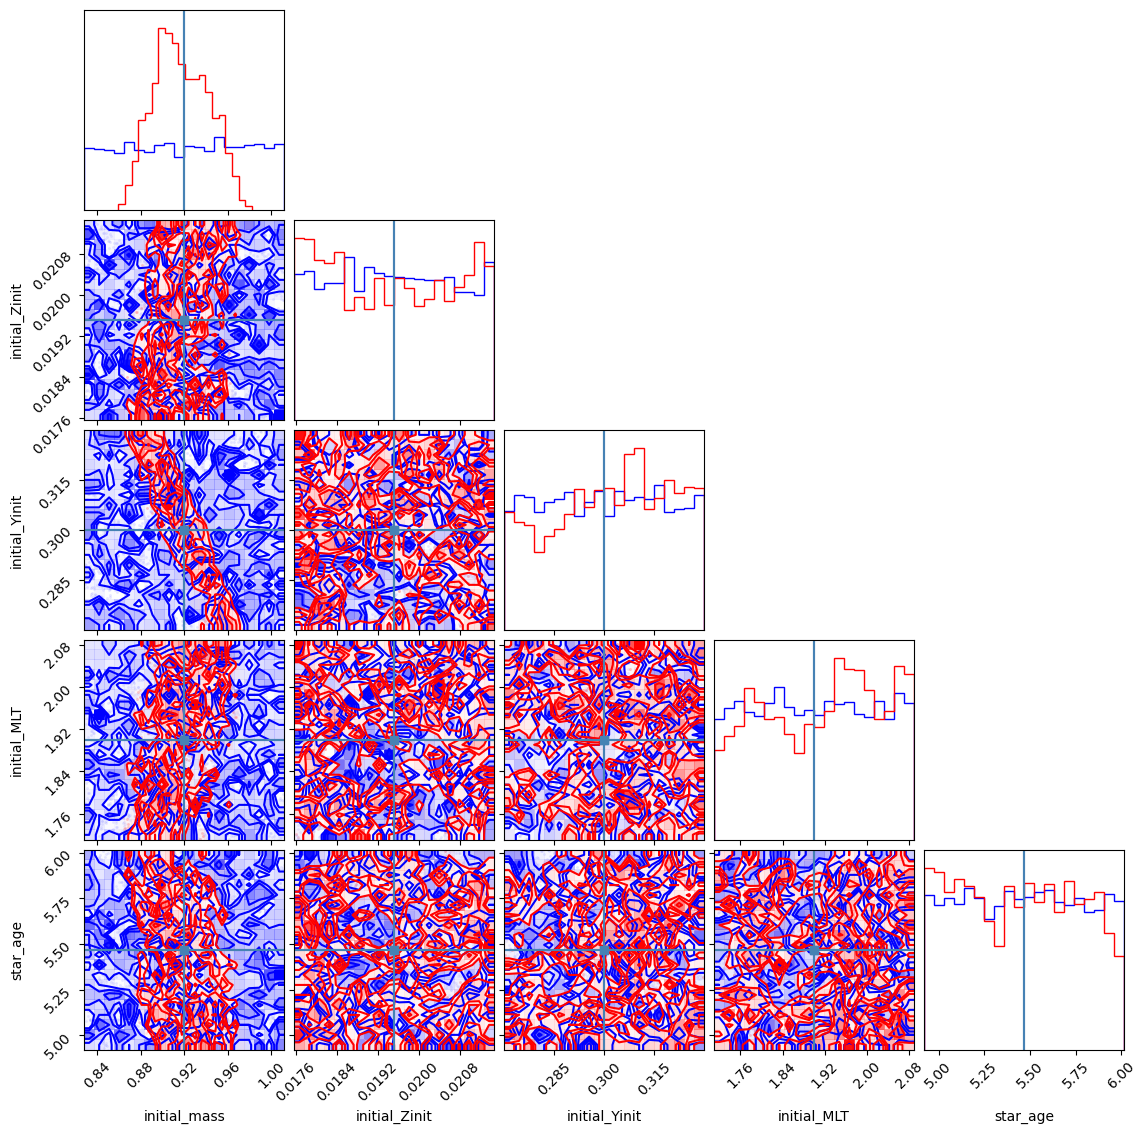

In [16]:
#prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});
#hist_kwargs={'density'=True}

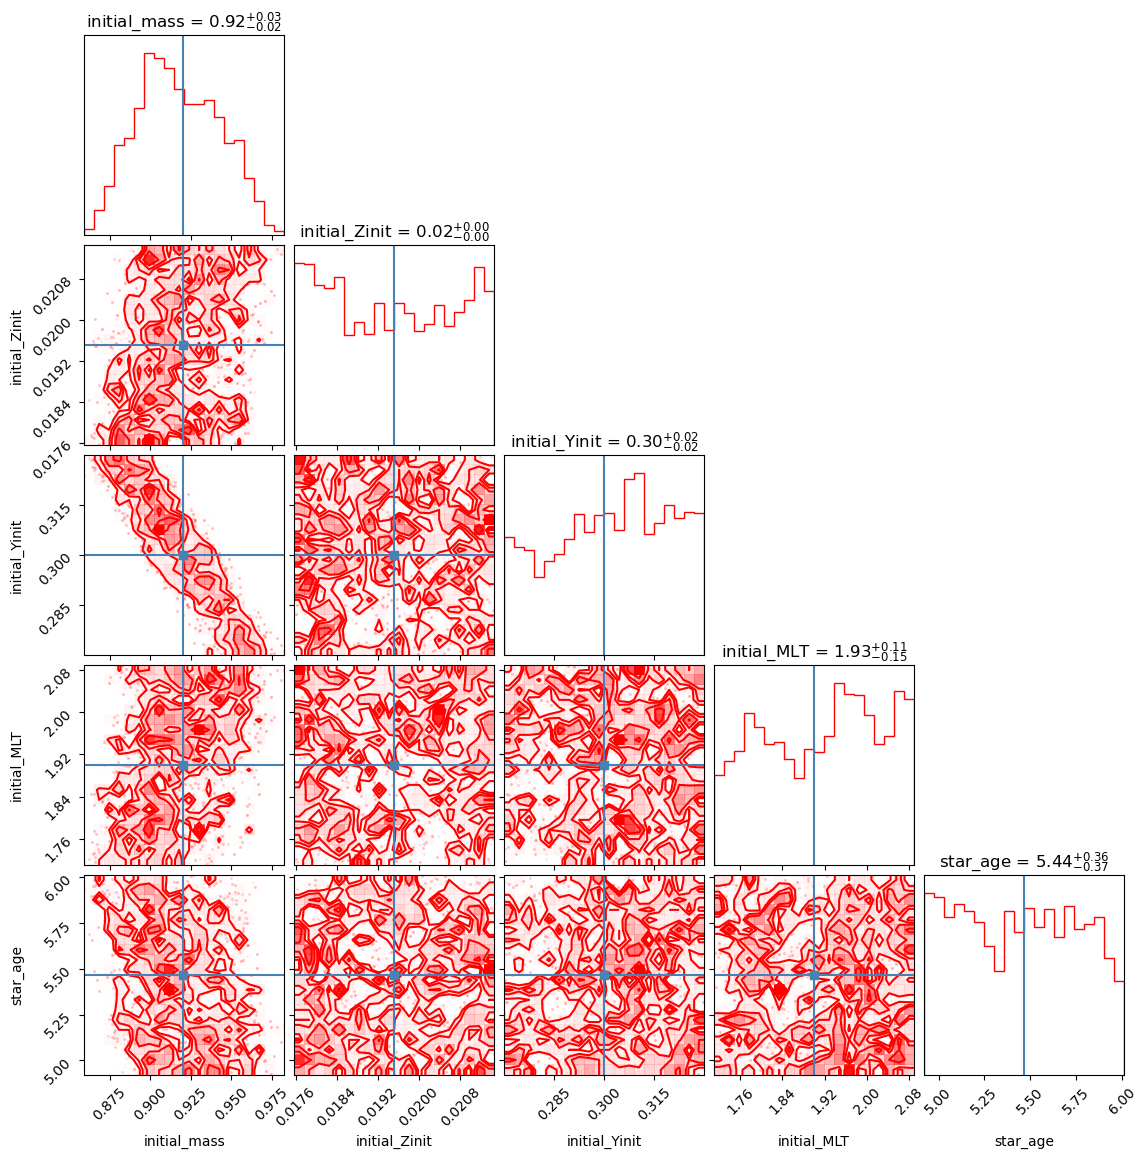

In [17]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True);